In [231]:
# Import Python librarie for data exploration and natural language processing
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS 
from gensim import corpora, models
import datetime as dt
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline

In [232]:
#food = pd.read_csv("food-enforcement.json")
with open('food-enforcement.json') as json_file:
    data = json.load(json_file)

In [233]:
food = pd.DataFrame(data['results'])

In [234]:
food.head()

,address_1,address_2,center_classification_date,city,classification,code_info,country,distribution_pattern,event_id,initial_firm_notification,...,product_type,reason_for_recall,recall_initiation_date,recall_number,recalling_firm,report_date,state,status,termination_date,voluntary_mandated
0,748 S Alameda St,,20120926,Los Angeles,Class II,not available.,United States,California,63150,E-Mail,...,Food,M & K Trading is recalling Korean Molluscan Sh...,20120921,F-2396-2012,M & K Trading Inc,20121003,CA,Terminated,20120926,Voluntary: Firm Initiated
1,4401 Foxdale St,,20120924,Irwindale,Class I,"UPC 7774523746, Use by dates 9/8/2012 or earli...",United States,Nationwide to following US States and Canada: ...,63062,Press Release,...,Food,"Firm is voluntarily recalling, out of an abund...",20120831,F-2382-2012,Ready Pac Foods Inc,20121003,CA,Terminated,20121025,Voluntary: Firm Initiated
2,2315 Moore Ave,,20120927,Fullerton,Class II,"UPC 0-30871-33001-2, Item # 0291710.",United States,Nationwide and Canada.,62991,Letter,...,Food,The firm recalled due to a potential non-safet...,20120712,F-2438-2012,Pulmuone Wildwood Inc,20121003,CA,Terminated,20121217,Voluntary: Firm Initiated
3,2315 Moore Ave,,20120927,Fullerton,Class II,"UPC 0-52334-11659-9, Item # 0291661.",United States,Nationwide and Canada.,62991,Letter,...,Food,The firm recalled due to a potential non-safet...,20120712,F-2436-2012,Pulmuone Wildwood Inc,20121003,CA,Terminated,20121217,Voluntary: Firm Initiated
4,1720 Locust Grove Road,,20120921,Manheim,Class II,"No codes; all product ""Purchase by date shown ...",United States,Product was distributed to specific wholesale ...,62465,Telephone,...,Food,FDA samples of product tested positive for Fum...,20120417,F-2374-2012,Haldeman Mills,20121003,PA,Terminated,20130716,Voluntary: Firm Initiated


In [235]:
columns = ['center_classification_date', 'city','classification', 'code_info', 'country', 'distribution_pattern',
       'event_id', 'initial_firm_notification', 'more_code_info', 'openfda', 'postal_code', 'product_description', 'product_quantity',
       'product_type', 'reason_for_recall', 'recall_initiation_date', 'recall_number', 'recalling_firm', 'report_date', 'state', 'status',
       'termination_date', 'voluntary_mandated']

In [236]:
food = food[columns]

In [237]:
food['new_recall_date'] = food['recall_initiation_date'].map(lambda x: dt.datetime.strptime(x, '%Y%m%d'))

In [238]:
food['recall_initiation_date'].min()

'02121207'

In [239]:
food['new_recall_date'].max()

datetime.datetime(2019, 7, 18, 0, 0)

## Let's explore the reason for recall column
Most of the recalls were due to bacterial contamination, lack of Good manufacturing practices(GMP) and poor temperature control. We would apply topic modelling to extract the 3 most important topics in that column

In [240]:
#food['reason_for_recall'].value_counts()[:30]

In [241]:
food['tokenized_reason'] = food['reason_for_recall'].apply(word_tokenize) 

In [242]:
food['tokenized_reason'].head()

0    [M, &, K, Trading, is, recalling, Korean, Moll...
1    [Firm, is, voluntarily, recalling, ,, out, of,...
2    [The, firm, recalled, due, to, a, potential, n...
3    [The, firm, recalled, due, to, a, potential, n...
4    [FDA, samples, of, product, tested, positive, ...
Name: tokenized_reason, dtype: object

In [243]:
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [244]:
food['tokenized_gram'] = food['reason_for_recall'].apply(generate_ngrams) 

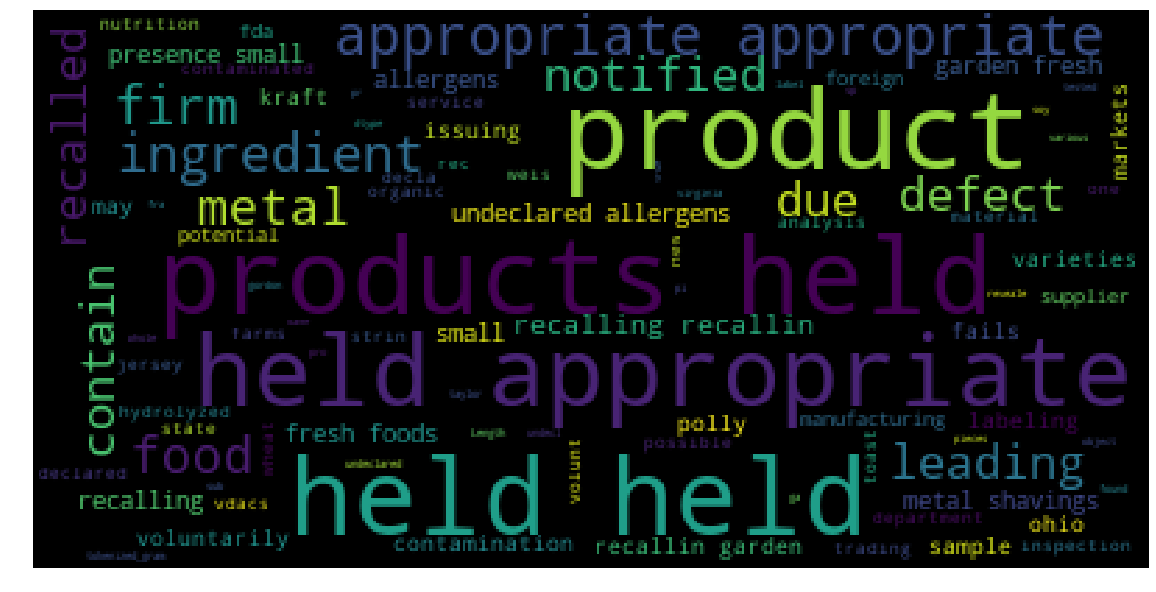

In [245]:
wordcloud_ = WordCloud(   background_color='black',
                          stopwords=set(STOPWORDS),
                          max_words=250,
                          max_font_size=40, 
                          random_state=1705
                         ).generate(str(food['tokenized_gram'].dropna()))
def cloud_plot(wordcloud):
    fig = plt.figure(1, figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
cloud_plot(wordcloud_)

In [252]:
def generate_lda(texts,no_passes=20):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=no_passes,minimum_probability=0)
    return lda_model

In [253]:
np.random.seed(1)
doc_clean = food['tokenized_gram'].tolist()
output = generate_lda(doc_clean)

In [254]:
output.print_topics(num_topics=5, num_words=5)

[(0,
  '0.023*"may contain" + 0.017*"contain undeclared" + 0.015*"product may" + 0.012*"undeclared milk." + 0.010*"due potential"'),
 (1,
  '0.012*"listeria monocytogenes" + 0.008*"recalled due" + 0.007*"ice cream" + 0.007*"due potential" + 0.006*"dietary supplements"'),
 (2,
  '0.026*"held appropriate" + 0.025*"temperature due" + 0.025*"mechanical malfunction" + 0.025*"malfunction transportation." + 0.025*"due mechanical"')]

### Using LDA, we can see that there are 3 topics describing the reasons for recall


In [ ]:
#doc_term_matrix

In [ ]:
#doc_topics, word_topics, phi_values = lda.get_document_topics(bow, per_word_topics=True)

In [ ]:
from itertools import chain
# Assigns the topics to the documents in corpus
lda_corpus = lda[doc_term_matrix]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print(round(threshold,3))

In [ ]:
#cluster1 = [j for i,j in zip(lda_corpus,doc_clean) if i[0][1] > threshold]
#cluster2 = [j for i,j in zip(lda_corpus,doc_clean) if i[1][1] > threshold]
#cluster3 = [j for i,j in zip(lda_corpus,doc_clean) if i[2][1] > threshold]

#print cluster1
#print cluster2
#print cluster3'''

In [ ]:
len(doc_clean)

In [ ]:
lda_corpus.

In [ ]:
p = pyLDAvis.gensim.prepare(topic_model, corpus, dictionary)
pyLDAvis.save_html(p, 'lda.html')

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', loaded_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=loaded_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [176]:
#food['reason_for_recall'].value_counts()[:20]